In [89]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import quantum as qm
import asymmetric as asym
import scipy.sparse.linalg as spla
import importlib
importlib.reload(asym)
from scipy.special import  comb

# Block Diagonal

In [61]:
L = 5; end = 20; n = 3; field_strength = 1

_,x_list,y_list, z_list = qm.get_sigma_lists(L, half=False)
H = asym.dense_H(L)
Z0 = z_list[0]
if (not field_strength is None):
    h = field_strength/2 # Take into account spin-1/2
    H = H + qm.get_local_field(z_list, np.random.rand(L)*2*h - h)

In [67]:
Hlist  = asym.mat2list(H)
Zlists = [asym.mat2list(Z) for Z in z_list]
Z0list = Zlists[0]
ZLlist = Zlists[L-1]

In [91]:
OTOCs = asym.zotoc_mat_exact(L, Hlist, Zlists, end=20, n=3)

NameError: name 'fore' is not defined

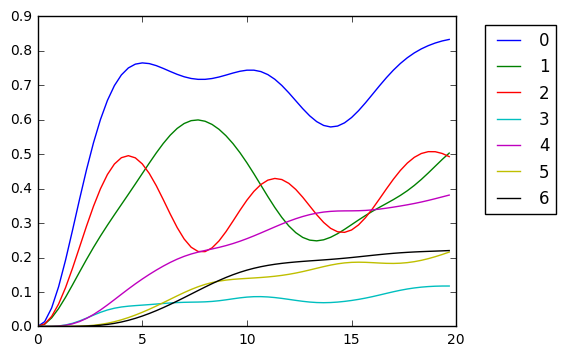

In [28]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# expm_mult, vectors

In [63]:
vec = qm.get_vec_Haar(2**L)
vecs = asym.arr2list(vec)

In [64]:
def zotoc_vec_expm(L, Hlist, Z0list, vecs, Zlists, end=20, n=3):
    e = spla.expm_multiply
    tot = end*n
    OTOCs = np.zeros((L,tot))
    for T in range(tot):
        t = T/n
        vbs  = [e(1j*H*t, Z0@e(-1j*H*t, vec)) for (H, Z0, vec) in zip(Hlist, Z0list, vecs)]

        for i in range(L):
            v1s = [e(1j*H*t, Z0@e(-1j*H*t, Zi@vec)) for (H, Z0, vec, Zi) in zip(Hlist, Z0list, vecs, Zlists[i])]
            v2s = [Zi@vb for (Zi, vb) in zip(Zlists[i], vbs)]
            OTOCs[i, T] = 1-sum([v2.conj().T@v1 for (v1, v2) in zip(v1s, v2s)]).real
    return OTOCs

In [86]:
OTOCs = asym.zotoc_vec_expm(L, Hlist, vecs, Zlists, end=20, n=3, fore=False)

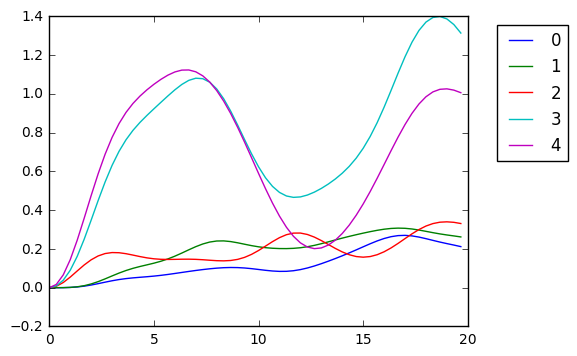

In [87]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# Hybrid Method

In [29]:
cutoff = 20
s_Hlist  =  [H for H in Hlist  if H.shape[0]<cutoff]
s_Zlists = [[Z for Z in z_list if Z.shape[0]<cutoff] for z_list in Zlists]
s_Z0list =  [Z for Z in Z0list if Z.shape[0]<cutoff]

l_Hlist  =  [H for H in Hlist  if H.shape[0]>=cutoff]
l_Zlists = [[Z for Z in z_list if Z.shape[0]>=cutoff] for z_list in Zlists]
l_Z0list =  [Z for Z in Z0list if Z.shape[0]>=cutoff]
l_vecs  =   [v for v in vecs   if len(v)>=cutoff]

In [31]:
OTOCs = zotoc_mat_exact(L, s_Hlist, s_Z0list, s_Zlists, end=20, n=3) + \
        zotoc_vec_expm( L, l_Hlist, l_Z0list, l_vecs, l_Zlists)

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


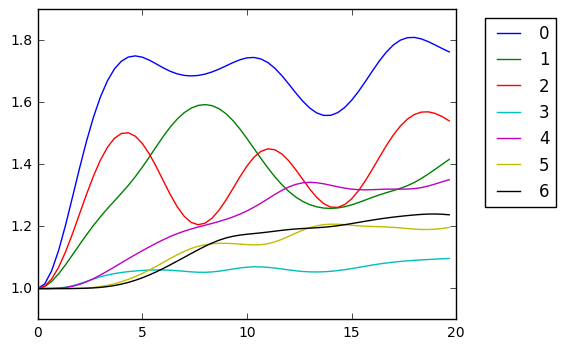

In [32]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# Standard Errors

In [48]:
def zotoc_vec_expm2(L, Hlist, Z0list, vecs, Zlists, end=20, n=3):
    e = spla.expm_multiply
    tot = end*n
    OTOCs = np.zeros((L,tot,L+1))
    for T in range(tot):
        t = T/n
        vbs  = [e(1j*H*t, Z0@e(-1j*H*t, vec)) for (H, Z0, vec) in zip(Hlist, Z0list, vecs)]

        for i in range(L):
            v1s = [e(1j*H*t, Z0@e(-1j*H*t, Zi@vec)) for (H, Z0, vec, Zi) in zip(Hlist, Z0list, vecs, Zlists[i])]
            v2s = [Zi@vb for (Zi, vb) in zip(Zlists[i], vbs)]
            OTOCs[i, T, :] = np.array([v2.conj().T@v1 for (v1, v2) in zip(v1s, v2s)]).real
    return OTOCs

In [60]:
nvecs = 2
OTOCss = np.zeros((nvecs,L,tot,L+1))
for i in range(nvecs):
    vec = qm.get_vec_Haar(2**L)
    vecs = asym.arr2list(vec)
    print(vecs[:2])
#     OTOCss[i] = zotoc_vec_expm2(L, Hlist, Z0list, vecs, Zlists, end=20, n=3)

[array([-0.01260265+0.01550546j]), array([-0.020159  +0.0192944j , -0.06695301+0.00372174j,
       -0.0395629 -0.05344914j, -0.01256567-0.04732404j,
       -0.03182347-0.09607322j, -0.03075813+0.00473691j,
        0.01256712+0.02458198j])]
[array([-0.02219311+0.05984664j]), array([ 0.00445356-0.10564877j,  0.07975633-0.12016731j,
        0.00592665+0.03306394j,  0.10290562-0.00317928j,
       -0.08607425-0.06692436j,  0.09229841-0.03687953j,
        0.02289131+0.11342592j])]


In [55]:
_, std = qm.mean_and_std(OTOCss)

In [59]:
std[:,30,:]

array([[1.06266254e-02, 4.69343101e-03, 2.64896851e-02, 1.54031592e-02,
        9.08077044e-03, 1.85385358e-02, 1.05770907e-02, 4.68182622e-03],
       [1.06266254e-02, 2.35024326e-03, 3.47833183e-02, 4.69395815e-02,
        1.27082632e-03, 8.63815530e-03, 7.63648392e-03, 4.68182622e-03],
       [1.06266254e-02, 1.90868230e-02, 2.81208826e-03, 3.05183261e-02,
        9.60490279e-05, 2.60020526e-02, 2.24917692e-03, 4.68182622e-03],
       [1.06266254e-02, 3.06027441e-02, 2.05130454e-03, 5.28066005e-02,
        1.70172357e-02, 8.92570038e-03, 6.76294101e-04, 4.68182622e-03],
       [1.06266254e-02, 3.43551553e-02, 3.22549103e-03, 4.29156803e-02,
        4.43631965e-02, 1.08887287e-02, 1.64084815e-05, 4.68182622e-03],
       [1.06266254e-02, 3.45287908e-02, 1.96037141e-03, 3.27553152e-02,
        3.59260134e-02, 2.08896643e-02, 7.41351467e-05, 4.68182622e-03],
       [1.06266254e-02, 3.40352195e-02, 1.28902169e-03, 2.34085891e-02,
        2.90957476e-02, 2.43381854e-02, 2.99315980e-04, 4.

In [73]:
np.zeros((3))

array([0., 0., 0.])